##### Homework Set 5

In [1]:
## MP 573 HW5
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy import signal, ndimage, misc
from skimage.data import shepp_logan_phantom
import scipy.stats as stats

font = {'weight' : 'normal',
        'size'   : 16}

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

## Problem 2.1: Law of large numbers

Example starting out with a uniform distribution. Modify the code as described in the question, to start out with a binomial, exponential, and Gaussian distributions. 

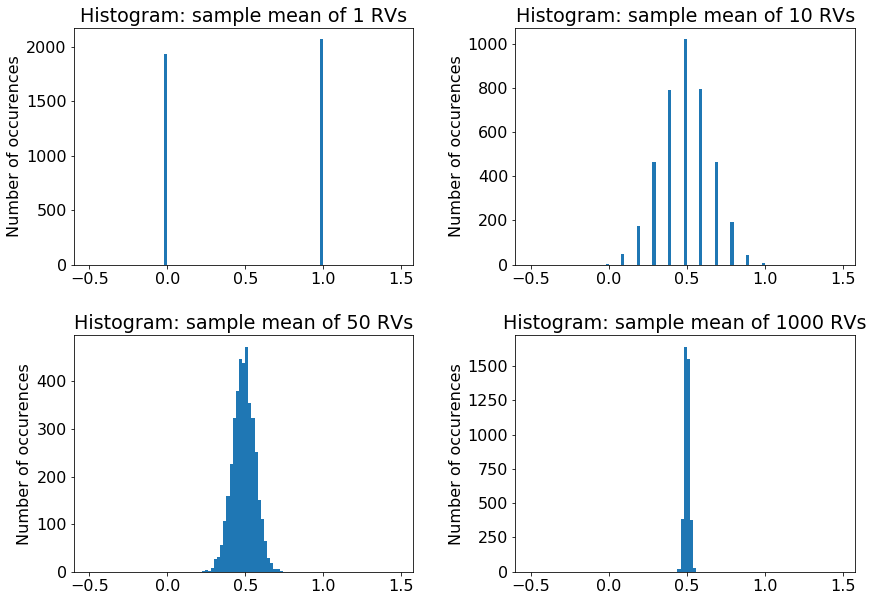

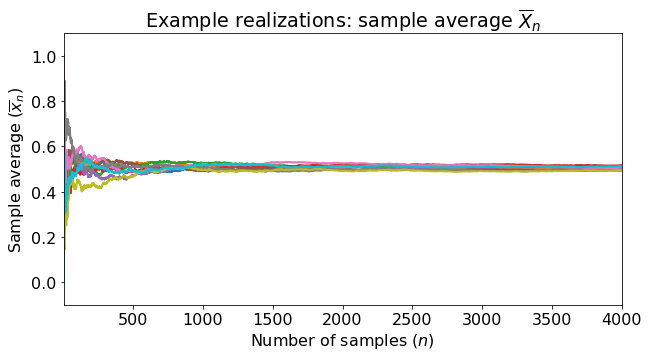

In [2]:
# Bernuilli distribution with parameter p
p = 0.5;

# Number of averages
Ave = [1,10,50,1000]

# Number of trials
N = 4000;
fig = plt.figure(figsize=(14,10))
plt.rc('font', **font)
fig.subplots_adjust(hspace=0.3,wspace=0.3)

for k in range(4):
    # Generate and show some data
    x = stats.bernoulli.rvs(p, size=[N,Ave[k]])
    xbar = np.mean(x,axis=1)
    plt.subplot(2,2,k+1)
    plt.title('Histogram: sample mean of ' + str(Ave[k]) + ' RVs')
    _ = plt.hist(xbar, bins=np.arange(-0.5,+1.5,0.02))
    plt.ylabel('Number of occurences');


# Now generate a few sequences Y_n
n_max = 4000
trials = 10
Ave = np.arange(n_max) + 1
xbar = 0.0*np.zeros((trials,n_max))
x = stats.bernoulli.rvs(p, size=[trials,n_max])
for k in np.arange(n_max):
    xcur = 1.0*x[:,0:(k+1)]
    xbar[:,k] = np.sum(xcur,axis=1)/(k+1)
    
# Plot the sequence of sample averages
plt.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.plot(Ave,xbar.T,linewidth=2.0)
plt.axis([1,n_max,-0.1,1.1])
plt.xlabel('Number of samples ($n$)')
plt.ylabel('Sample average ($\overline{x}_n$)')
plt.title('Example realizations: sample average $\overline{X}_n$');



## Problem 2.2: Central limit theorem

Example starting out with a uniform distribution. Modify the code as described in the question, to start out with a binomial, exponential, and Gaussian distributions. 

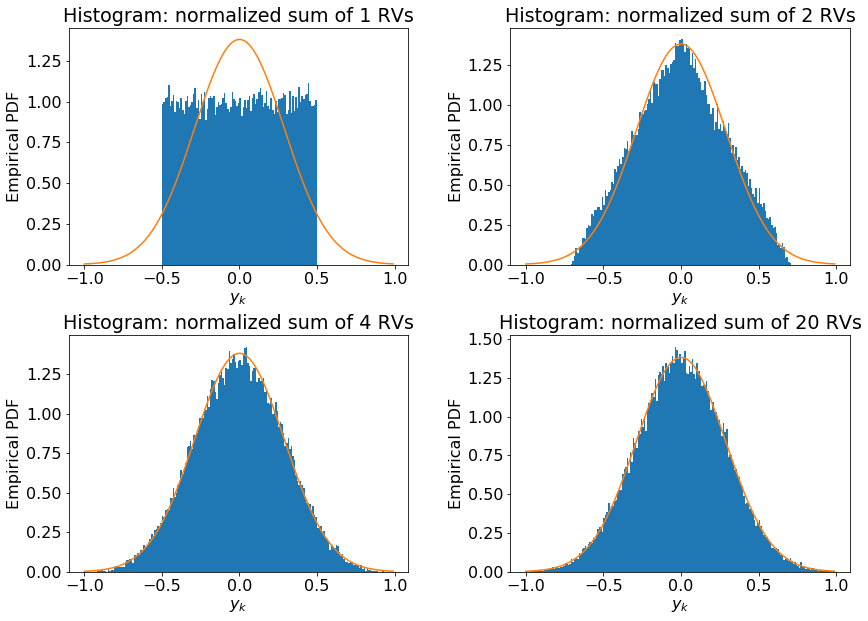

In [3]:
# Uniform example
# Distribution parameters
a = -0.5
b = 0.5
mu = (b+a)/2
var = 1/12*(b-a)**2

# Gaussian of mean zero and variance 1/12
xvals = np.arange(a-0.5,b+0.5,0.01)
pdf_gauss = stats.norm.pdf(xvals,mu,np.sqrt(var))


# Number of averages
Ave = [1,2,4,20]

# Number of trials
N = 50000;
fig = plt.figure(figsize=(14,10))
plt.rc('font', **font)
fig.subplots_adjust(hspace=0.3,wspace=0.3)

for k in range(4):
    # Generate and show some data
    x = stats.uniform.rvs(a, b-a, size=[N,Ave[k]])
    y = (np.sum(x,axis=1) - Ave[k]*mu)/np.sqrt(Ave[k])
    plt.subplot(2,2,k+1)
    plt.title('Histogram: normalized sum of ' + str(Ave[k]) + ' RVs')
    _ = plt.hist(y, bins=np.arange(a-0.5,b+0.5,0.01), density=True) # Histogram is normalized to integrate to 1 (ie: empirical PDF)
    plt.plot(xvals,pdf_gauss)
    plt.xlabel('$y_k$');
    plt.ylabel('Empirical PDF');

## Problem XX. Sensitivity and Specificity 



AUC for single-pixel system (empirical):
0.713825135


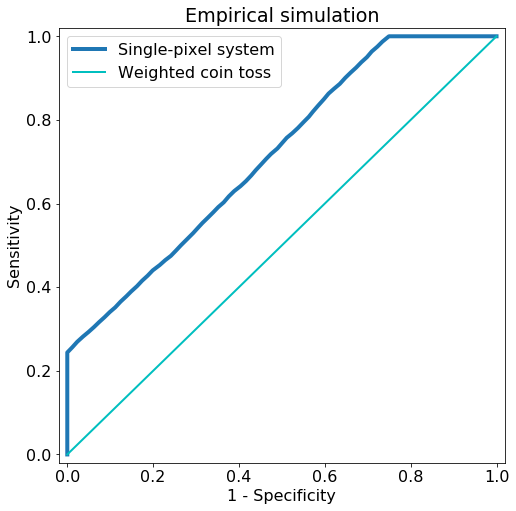

In [6]:
# Single pixel detection
mu_h = 50 # Mean in healthy tissue
mu_d = 60 # Mean in diseased tissue
a = -20 # lower bound of pixel noise
b = 20 # upper bound of pixel noise
v = np.linspace(30,80,num=101, endpoint=True) # A few thresholds to consider

## Empirical sensitivity and specificity
N = 10000
xh = stats.uniform.rvs(mu_h + a, b-a, size=N)
xd = stats.uniform.rvs(mu_d + a, b-a, size=N)

N_correctpositive = 0*v
N_correctnegative = 0*v
for k in range(v.size):
    N_correctpositive[k] = np.sum(xd > v[k])
    N_correctnegative[k] = np.sum(xh < v[k])
emp_sens = N_correctpositive/N
emp_spec = N_correctnegative/N
fig,ax = plt.subplots(figsize=(8,8))
plt.rc('font', **font)
fig.subplots_adjust(hspace=0.3,wspace=0.3)
plt.plot(1-emp_spec,emp_sens,linewidth=4)
plt.xlim([-0.02,1.02])
plt.ylim([-.02,1.02])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Empirical simulation')


# Add the weighted coin ROC curve
p = np.linspace(0,1,101,endpoint=True)
plt.plot(p,p,'c',linewidth=2);
ax.legend(['Single-pixel system', 'Weighted coin toss'])

# Let us calculate a simple approximation to AUC
dx = np.abs(np.diff(emp_spec))
meany = 0.5*(emp_sens[0:-1] + emp_sens[1:])
AUC_single_pixel_emp = np.sum(dx*meany)

print('AUC for single-pixel system (empirical):')
print(AUC_single_pixel_emp)



AUC for single-pixel system (empirical):
0.9730381349999999


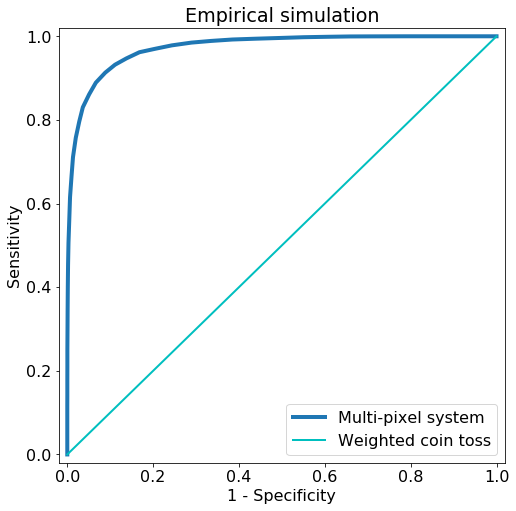

In [8]:
# Multi pixel detection
mu_h = 50 # Mean in healthy tissue
mu_d = 60 # Mean in diseased tissue
a = -20 # lower bound of pixel noise
b = 20 # upper bound of pixel noise
n = 10 # Number of pixels
v = np.linspace(30,80,num=101, endpoint=True) # A few thresholds to consider


## Empirical sensitivity and specificity
N = 10000
xh = stats.uniform.rvs(mu_h + a, b-a, size=[N,n])
xd = stats.uniform.rvs(mu_d + a, b-a, size=[N,n])
zh = np.mean(xh,axis=1)
zd = np.mean(xd,axis=1)

N_correctpositive = 0*v
N_correctnegative = 0*v
for k in range(v.size):
    N_correctpositive[k] = np.sum(zd > v[k])
    N_correctnegative[k] = np.sum(zh < v[k])
emp_sens = N_correctpositive/N
emp_spec = N_correctnegative/N
fig,ax = plt.subplots(figsize=(8,8))
plt.rc('font', **font)
fig.subplots_adjust(hspace=0.3,wspace=0.3)
plt.plot(1-emp_spec,emp_sens,linewidth=4)
plt.xlim([-0.02,1.02])
plt.ylim([-.02,1.02])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Empirical simulation')


# Add the weighted coin ROC curve
p = np.linspace(0,1,101,endpoint=True)
plt.plot(p,p,'c',linewidth=2);
ax.legend(['Multi-pixel system', 'Weighted coin toss'])

# Let us calculate a simple approximation to AUC
dx = np.abs(np.diff(emp_spec))
meany = 0.5*(emp_sens[0:-1] + emp_sens[1:])
AUC_single_pixel_emp = np.sum(dx*meany)

print('AUC for single-pixel system (empirical):')
print(AUC_single_pixel_emp)

